# Phonon transport in Graphene

### Objective 1

Reproducing the DOS graphs in Ref "[Phonon transmission and thermal conductance across graphene/Cu interface](http://aip.scitation.org/doi/10.1063/1.4821439)"


### Geometry script
```tcl
package require nanotube
package require topotools

set molname graphene

graphene -lx 4 -ly 4 -type zigzag -b 0
set sel [atomselect top all]
$sel moveby {0.7090 0.0 0.0}
$sel writepdb $molname.pdb
$sel writepsf $molname.psf
topo writelammpsdata $molname.lmpsys

set mm [measure minmax $sel]
set xlo [format %.4f [expr [lindex $mm 0 0]+0.0] ]
set xhi [format %.4f [expr [lindex $mm 1 0]+1.4200] ]; # very imp
set ylo [format %.4f [expr [lindex $mm 0 1]+0.0] ]
set yhi [format %.4f [expr [lindex $mm 1 1]+1.2298] ]; # very imp
set zlo [format %.4f [expr [lindex $mm 0 2]-1.0] ]
set zhi [format %.4f [expr [lindex $mm 1 2]+1.0] ]

exec sed -i "12s/.*/  $xlo $xhi  xlo xhi/" $molname.lmpsys
exec sed -i "13s/.*/  $ylo $yhi  ylo yhi/" $molname.lmpsys
exec sed -i "14s/.*/  $zlo $zhi  zlo zhi/" $molname.lmpsys

exec rm -f $molname.pdb
mol delete all
exit
```

### Graphene Geometry



![Graphene](https://rawgit.com/abhijithanandan/the-phonon-project/master/Graphene.png)

### Specs

No. of atoms | Type | n x m
:---: | :---: | :---:
680 | armchair | 4 x 4

#### Lammps Code
```lammps
units		real
atom_style	full

#----------------------------------------------------
#INPUT FILE
#----------------------------------------------------

read_data	inputFiles/graphene.lmpsys

#----------------------------------------------------
#POTENTIAL
#----------------------------------------------------

pair_style 	rebo
pair_coeff 	* * inputFiles/CH.airebo.real C 

#----------------------------------------------------
#INITIALIZATION
#----------------------------------------------------

velocity       all create 300 1234567 mom yes rot yes 

#----------------------------------------------------
#FORCE
#----------------------------------------------------

variable        Fx equal fcm(all,x)
variable        Fy equal fcm(all,y)


#----------------------------------------------------
#LOG
#----------------------------------------------------

thermo_style    custom step temp pe ke etotal 
thermo          1000  
log             outputFiles/thermo.log

#----------------------------------------------------
#TIMESTEP
#----------------------------------------------------

timestep	1

#----------------------------------------------------
#FIXES
#----------------------------------------------------

fix 		fxnvt all nvt temp 300.0 300.0 100.0
fix 		fxmom all momentum 1 linear 1 1 1 angular

#----------------------------------------------------
#EQUILIBRATION RUN
#----------------------------------------------------

run 		1000000

#----------------------------------------------------
#TEST RUN 
#----------------------------------------------------

unfix		fxnvt
fix		fxnve all nve 

run 		10000

unfix		fxnve
fix		fxnvt all nvt temp 300.0  300.0 100.0

#----------------------------------------------------
#DUMP FILES
#----------------------------------------------------

dump            dmpvel all custom 100 outputFiles/vel.dat id vx vy vz
dump            dmpall all dcd 1000 outputFiles/graphene.dcd   

#----------------------------------------------------
#PRODUCTION RUN
#----------------------------------------------------

run 		1000000
```

<blockquote>
Now the temperature and energy values are extracted form log file and written to the file 'thermo.dat' using the following bash commands
</blockquote>

``` bash
awk  ' NR>=29 && NR<=1029 {print $0} ' thermo.log > thermo.dat    
awk  ' NR>=1072 && NR<=1081 {print $0} ' thermo.log >> thermo.dat
awk  ' NR>=1131 && NR<=2130 {print $0} ' thermo.log >> thermo.dat
```

<blockquote>
The temperature and energy are plotted over time as follows:
</blockquote>

## Temperature vs Time

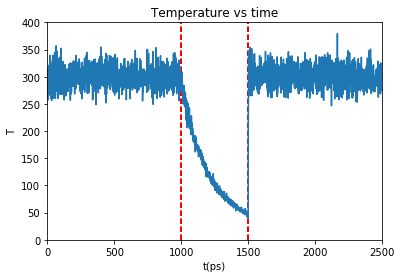

In [5]:
import matplotlib.pyplot as plt
import numpy as np

data = np.loadtxt("thermo.dat")
T = data[:,1]
t = data[:,0]
t = t/1000
plt.axvline(x=1000, color = 'r', linewidth=2, linestyle='dashed')
plt.axvline(x=1500, color = 'r', linewidth=2, linestyle='dashed')
plt.xlabel("t(ps)")
plt.axis([0,2500,0,400])
plt.ylabel("T")
plt.title("Temperature vs time")
plt.plot(t,T)
plt.show()

## Potential Energy vs time

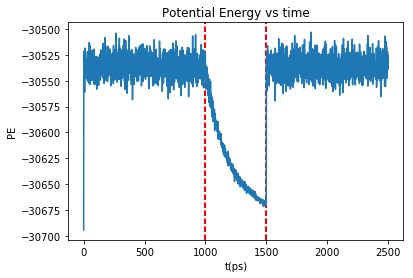

In [15]:
import matplotlib.pyplot as plt
import numpy as np

data = np.loadtxt("thermo.dat")
PE = data[:,2]
t = data[:,0]
t = t/1000                                                          #converting time to ps 
plt.axvline(x=1000, color = 'r', linewidth=2, linestyle='dashed')
plt.axvline(x=1500, color = 'r', linewidth=2, linestyle='dashed')
plt.xlabel("t(ps)")
#plt.axis([0,2500,0,400])
plt.ylabel("PE")
plt.title("Potential Energy vs time")
plt.plot(t,PE)
plt.show()

## Kinetic Energy vs time

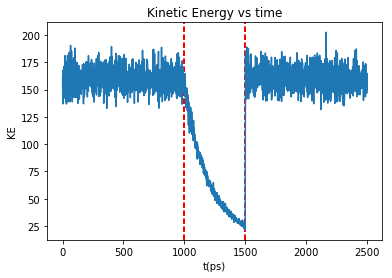

In [16]:
import matplotlib.pyplot as plt
import numpy as np

data = np.loadtxt("thermo.dat")
KE = data[:,3]
t = data[:,0]
t = t/1000                                                          #converting time to ps 
plt.axvline(x=1000, color = 'r', linewidth=2, linestyle='dashed')
plt.axvline(x=1500, color = 'r', linewidth=2, linestyle='dashed')
plt.xlabel("t(ps)")
#plt.axis([0,2500,0,400])
plt.ylabel("KE")
plt.title("Kinetic Energy vs time")
plt.plot(t,KE)
plt.show()

## Total Energy vs Time

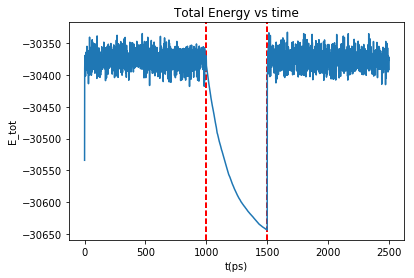

In [7]:
import matplotlib.pyplot as plt
import numpy as np

data = np.loadtxt("thermo.dat")
E = data[:,4]
t = data[:,0]
t = t/1000                                                          #converting time to ps 
plt.axvline(x=1000, color = 'r', linewidth=2, linestyle='dashed')
plt.axvline(x=1500, color = 'r', linewidth=2, linestyle='dashed')
plt.xlabel("t(ps)")
#plt.axis([0,2500,0,400])
plt.ylabel("E_tot")
plt.title("Total Energy vs time")
plt.plot(t,E)
plt.show()

<blockquote>
The Force Fx and Fy are found almost zero in log file and hence it's assumed that there is no stress acting on the body.
</blockquote>

## Post Processing


<blockquote>
The velocity file <b>vel.dat</b> is obtained and it is sorted and spereate velocity files are written for each atom using the following <b>bash</b> script:
</blockquote>



```bash
awk '/ITEM: ATOMS/,/ITEM: TIMESTEP/' velocity.dat > tmp.dat
sed -i '/ITEM/d' tmp.dat
mv tmp.dat vel.dat

sort -n -k1 vel.dat > velSorted.dat

awk 'NR%5000==0{print $1}' velSorted.dat > ids.dat     #Since data collected every 100 steps for 500000 steps
        
i=1
num=1
while [ ${num} ]; 
do
        awk '$1=='${num}'{print $0}' velSorted.dat > velxyz.tmp
        awk '{r=($2*$2+$3*$3+$4*$4)**0.5;}{printf"%d %0.20f %0.20f %0.20f %0.20f\n",$1,$2,$3,$4,r;}' velxyz.tmp > vel.tmp
        cp vel.tmp vel${num}.txt
        echo done $num 
        rm -f *.tmp
        num=$(sed "${i}q;d" ids.dat)
        i=$(($i+1))
done
```


<blockquote>

Once the velocity files are obtained the following python script is used to calculate DOS from eqn:
</blockquote>


$$ DOS = fft \langle V \bigodot V \rangle $$

0
1
2
3
4
5
6
7
8
9


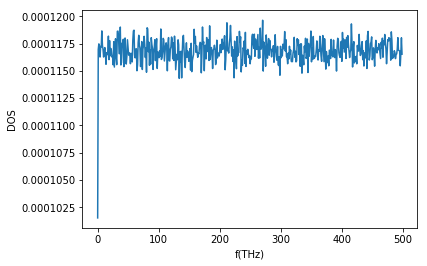

array([ 0.00101525,  0.00116962,  0.00117468, ...,  0.00117128,
        0.00117468,  0.00116962])

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import scikits.talkbox.tools as tl
ids = np.loadtxt("ids.dat")

tsteps = 10001
nvel = 1000
count = tsteps/nvel
n = 2**tl.nextpow2(nvel)
Dsum = 0
natoms = 180
Dt = 1
for j in range(count):
    Dx = 0
    Dy = 0
    Dz = 0
    for i in ids:
        val = int(i)
        fname = "vel"+str(val)+".txt"
        data = np.loadtxt(fname)
        Vx = data[1+nvel*(j):nvel*(j+1),1]
        Vy = data[1+nvel*(j):nvel*(j+1),2]
        Vz = data[1+nvel*(j):nvel*(j+1),3]
        Dxsum = np.fft.fft(Vx,n)
        Dx = Dx + np.abs(Dxsum/n)
        Dysum = np.fft.fft(Vy,n)
        Dy = Dy + np.abs(Dysum/n)
        Dzsum = np.fft.fft(Vz,n)
        Dz = Dz + np.abs(Dzsum/n)
    print j   
    D = (Dx+Dy+Dz)/3/natoms
    Dsum = Dsum + D

DOS = Dsum/count
N = np.size(Dsum)
DOS = DOS[:N/2]
freq = np.fft.fftfreq(N,d = 0.001)
freq = freq
freq = freq[:N/2]
#freq = (1/(n*Dt*1e-15))*((0:np.size(DOS)-1)/1e15)
plt.xlabel("f(THz)")
plt.ylabel("DOS")
plt.plot(freq,DOS)
plt.show()
Dsum